In [1]:
import numpy as np
import tensorflow as tf
# next line only for colab
%tensorflow_version 2.x
# import tensorflow-datasets to be able to access the tensorflow inbuilt datasets
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# 1. Dataset

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

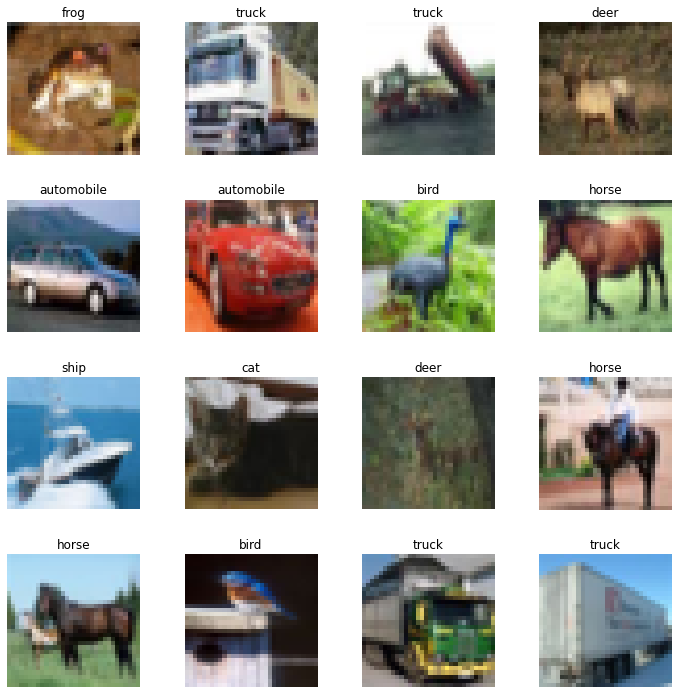

In [3]:
# Plot some images together with their labels
label_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
fig, ax = plt.subplots(4,4, figsize = (10,10))
fig.tight_layout()
ax = ax.flatten()
for i in range(16):
  ax[i].imshow(train_images[i]/255)
  ax[i].set_title(label_names[int(train_labels[i])])
  ax[i].axis('off')

## Data Generator
### The code below can be used for data augmentation. As it only marginally increased the test accuracy for our model we chose to leave it out due to increased training time.

```
# Create a generator with certain data manipulations
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 50,
    brightness_range = (.4,.8),
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True
)

# Create an iterator using datagen.flow
train_generator = datagen.flow(train_images, train_labels, batch_size = 256)

# Plot newly generated images
fig, ax = plt.subplots(1,5, figsize = (10,10))
for img, _ in train_generator:
    for i in range(0, 5):
        ax[i].imshow(img[i])
    plt.show()
    break

# Define our own generator which returns a certain number of batches
def generator(num_batches):
  for i, train_tuple in enumerate(train_generator):
    yield train_tuple
    if i >= num_batches:
      return
      
```

### Input pipeline for the data generator

```
num_batches = 150

train_dataset = tf.data.Dataset.from_generator(generator, (tf.float32, tf.float32), args=(tf.constant(num_batches),))
train_dataset = train_dataset.map(lambda img, lbl: (img, tf.one_hot(tf.cast(lbl, tf.uint8),10)))
train_dataset = train_dataset.map(lambda img, lbl: (img, tf.reshape(lbl, (-1,10)))).prefetch(256)


test_dataset_images = tf.data.Dataset.from_tensor_slices(test_images)
test_dataset_targets = tf.data.Dataset.from_tensor_slices(test_labels)
test_dataset_images = test_dataset_images.map(lambda img: tf.cast(img/255, tf.float32))
test_dataset_targets = test_dataset_targets.map(lambda lbl: tf.one_hot(lbl,10))
test_dataset_targets = test_dataset_targets.map(lambda lbl : tf.reshape(lbl, (-1,)))
test_dataset = tf.data.Dataset.zip((test_dataset_images, test_dataset_targets)).shuffle(buffer_size=10000, reshuffle_each_iteration=True).batch(256).prefetch(256)

```

## Input pipeline


In [4]:
# tf.data.Dataset.from_tensor_slices creates a tf.dataset from a tensor. The elements of the dataset are slices of the first tensor dimension
train_dataset_images = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset_targets = tf.data.Dataset.from_tensor_slices(train_labels)

# We want the labels to be onehot encoded and reshaped such that they are the same dimension as the output. 
# Furthermore, we normalize the images to a scale between 1 and 0.
train_dataset_images = train_dataset_images.map(lambda img: tf.cast(img/255, tf.float32))
train_dataset_targets = train_dataset_targets.map(lambda lbl: tf.one_hot(lbl,10))
train_dataset_targets = train_dataset_targets.map(lambda lbl : tf.reshape(lbl, (-1,)))

train_dataset = tf.data.Dataset.zip((train_dataset_images, train_dataset_targets)).shuffle(buffer_size=10000, reshuffle_each_iteration=True).batch(128).prefetch(30)


# Repeat for test data
test_dataset_images = tf.data.Dataset.from_tensor_slices(test_images)
test_dataset_targets = tf.data.Dataset.from_tensor_slices(test_labels)

test_dataset_images = test_dataset_images.map(lambda img: tf.cast(img/255, tf.float32))
test_dataset_targets = test_dataset_targets.map(lambda lbl: tf.one_hot(lbl,10))
test_dataset_targets = test_dataset_targets.map(lambda lbl : tf.reshape(lbl, (-1,)))

test_dataset = tf.data.Dataset.zip((test_dataset_images, test_dataset_targets)).shuffle(buffer_size=10000, reshuffle_each_iteration=True).batch(128).prefetch(30)


In [9]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model): 
    """Class for creating a Neural Network which inherits from the Model class from keras 
    """

    def __init__(self):
      """Initialize a network with a variable amount of keras.Layers
      """
      # Use the keyword super to allow our network to access the init() form the keras Model class
      super(Model, self).__init__()

      # We use a list to simplify the call function
      self.layerlist = [
                        
      # Define the layers structure.
      # Batch Normalization: We use batch normalization to allow more stable gradients
      # Dropout: We use dropout to reduce the risk of overfitting caused by the network relying too much on single neurons
      # Flatten: We use a Flatten() layer that passes the input into a Dense layer of 128 neurons inbetween
      tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(1,1), padding="same",  activation=None, input_shape=(32,32,3)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ReLU(),
      tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(1,1), padding="same",  activation=None),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ReLU(),
      tf.keras.layers.MaxPool2D(pool_size=(2,2)),
      tf.keras.layers.Dropout(0.3),

      tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(1,1), padding="same",  activation=None),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ReLU(),
      tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(1,1), padding="same",  activation=None),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ReLU(),
      tf.keras.layers.MaxPool2D(pool_size=(2,2)),
      tf.keras.layers.Dropout(0.3),

      tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(1,1), padding="same",  activation=None),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ReLU(),
      tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(1,1), padding="same",  activation=None),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ReLU(),
      tf.keras.layers.MaxPool2D(pool_size=(2,2)),
      tf.keras.layers.Dropout(0.3),

      tf.keras.layers.MaxPool2D(pool_size=(2,2)),
      tf.keras.layers.Dropout(0.3),

      tf.keras.layers.Flatten(),

      tf.keras.layers.Dense(units=128, activation = None),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ReLU(), 

      tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax)
      ]  

    # Use the decorator @tf.function to speed up the model call. 
    # Furthermore, we pass a training flag such that we only use our regularization methods during training. 
    # We also included this training flag in the train_step and test function  
    @tf.function    
    def call(self, x, training = True):
      """Activate our model propagating the input through the network layer by layer

      Arguments:
        x (Tensor): Tensor containing the input to our network
        training (Boolean): Indicates whether regularization methods should be used or not when calling the model 

      Returns:
        x (Tensor): Tensor containing the probabilities for the two classes
      """

      for layer in self.layerlist:
        x = layer(x, training = training)
      return x
  

In [6]:
def train_step(model, input, target, loss_function, optimizer, training = True):
  """Perform a training step for a given Neural Network by
  1. Propagating the input through the network
  2. Calculating the loss between the networks output and the true targets 
  2. Performing Backpropagation and Updating the trainable variables with the calculated gradients 
 
  Arguments:
    model (Model): given instance of an initialised Neural Network with all its parameters
    input (EagerTensor): Tensor containing the input data 
    target (EagerTensor): Tensor containing the respective targets 
    loss_function (keras.losses): function from keras to calculate the loss
    optimizer (keras.optimizers): function from keras defining the to be applied optimizer during learning 
    training (Boolean): Indicates whether regularization methods should be used or not when calling the model 
 
  Returns:
    loss (EagerTensor): Tensor containing the loss of the Network 
  """
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    # 1.
    prediction = model(input, training)
    # 2.
    loss = loss_function(target, prediction)
    # 3.
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
 
  return loss 
 
def test(model, test_data, loss_function, training = False):
  """Tests the models accuracy and loss over the given data set with a given loss_function
 
  Arguments:
    model (Model): given instance of an initialised Neural Network with all its parameters
    test_data (Dataset): test dataset to test the NN on 
    loss_function (keras.losses): function from keras to calculate the loss
    training (Boolean): Indicates whether regularization methods should be used or not when calling the model 
 
  Returns:
    test_loss (float): Average loss of the Neural Network over the test set
    test_accuracy (float): Average accuray of the Neural Network over the test set
  """
  # test over complete test data
  test_accuracy_aggregator = []
  test_loss_aggregator = []
  
  for (input, target) in test_data:
    prediction = model(input, training)
    
    # calculates the loss value (as a tensors) for an entire batch 
    sample_test_loss = loss_function(target, prediction)
 
    # creates a boolean array of dimension (100,) for each batch 
    # each entry represents whether one (sequence, label) pair was predicted correctly 
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
 
    # take the mean over each boolean array to obtain the average accuracy for one batch 
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
 
    # append the mean of all batch accuracies  
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))
 
  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)
 
  return test_loss, test_accuracy

In [8]:
# From IPython.display we import clear_output() in order to be able to clear the print statements after each epoch
from IPython.display import clear_output

tf.keras.backend.clear_session()
 
### Hyperparameters
num_epochs = 100
learning_rate = 0.001
running_average_factor = 0.95
 
# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy(learning_rate)
# Initialize the optimizer: Adam with default parameters.
optimizer = tf.keras.optimizers.Adam()
 
# Initialize lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []
train_accuracies = []
 
# testing once before we begin on the test data
test_loss, test_accuracy = test(model = model, test_data = test_dataset, loss_function = cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)
 
# check how model performs on train data once before we begin
train_loss, train_accuracy = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)

print("Initial Train Accuracy; " + str(round(train_accuracy, 4)))
print("Initial Test Accuracy; " + str(round(test_accuracy, 4)))

# We want our model to have a better test accuracy than 85% (see below)
best_test_sofar = 0.85

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    
    # training (and checking in with training)
    running_average = 0
    for (input,target) in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)
 
    # testing
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)

    change_test = test_accuracy-test_accuracies[-1]
    test_accuracies.append(test_accuracy)

    _, train_accuracy = test(model, train_dataset, cross_entropy_loss)
    change_train = train_accuracy-train_accuracies[-1]
    train_accuracies.append(train_accuracy)

    # We print useful information about each epoch
    clear_output()
    print('Epoch: __ ' + str(epoch))
    print('Train Accuracy: ' + str(round(train_accuracy, 4)))
    print('Train Auccuracy Difference to Previous Epoch: ' + str(round(change_train,4)))
    print('Best Train Accuracy So Far: ' + str(round(np.max(train_accuracies),4)) + ' Reached in Epoch: ' + str(np.argmax(train_accuracies)-1))
    print()
    print('Test Accuracy: ' + str(round(test_accuracy, 4)))
    print('Test Auccuracy Difference to Previous Epoch: ' + str(round(change_test,4)))
    print('Best Test Accuracy So Far: ' + str(round(np.max(test_accuracies),4)) + ' Reached in Epoch: ' + str(np.argmax(test_accuracies)-1))

  # We save the model that was able to archieve the best test accuracy over all epochs (The first model we save needs to surpass 85%)
    if (test_accuracy > best_test_sofar):
      best_test_sofar = test_accuracy
      model.save('best_model')


Epoch: __ 99
Train Accuracy: 0.9174
Train Auccuracy Difference to Previous Epoch: -0.0034
Best Train Accuracy So Far: 0.9327 Reached in Epoch: 95

Test Accuracy: 0.8445
Test Auccuracy Difference to Previous Epoch: -0.002
Best Test Accuracy So Far: 0.8616 Reached in Epoch: 95


Text(50, 0.6, 'best test accuracy 86.16%')

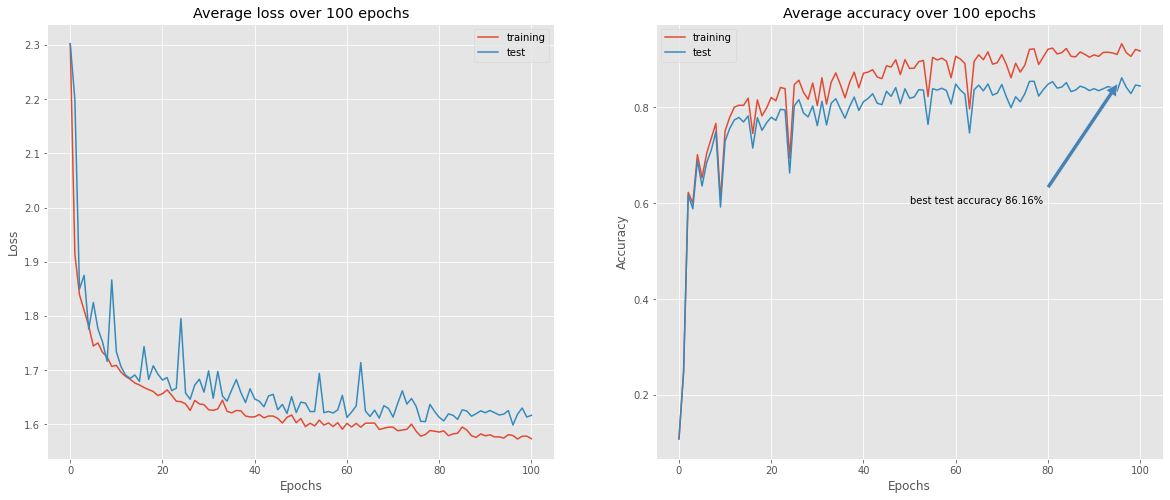

In [13]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.

# change the style of the plots to a nicer theme

plt.style.use('ggplot')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (20, 8))
# plot for average loss
ax[0].plot(train_losses, label='training')
ax[0].plot(test_losses, label='test')
ax[0].set(ylabel='Loss', xlabel='Epochs', title='Average loss over 100 epochs')
ax[0].legend()

# plot for average accuracy, with annotation for the last accuracy value on our test data 
ax[1].plot(train_accuracies, label='training')
ax[1].plot(test_accuracies, label='test')
ax[1].set(ylabel='Accuracy', xlabel='Epochs', title='Average accuracy over 100 epochs')
ax[1].legend()
ax[1].annotate(f'best test accuracy {round(test_accuracies[np.argmax(test_accuracies)], 4)*100}%', xy=(np.argmax(test_accuracies), test_accuracies[np.argmax(test_accuracies)]), xytext=(50, 0.6), arrowprops=dict(facecolor='steelblue', shrink=0.05))